In [87]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier

from sklearn.ensemble import GradientBoostingClassifier

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [65]:
'''
This is pre-groomed data from the Prep_Model_Data notebook
'''

data_dir_june = '/Users/briandalessandro/Documents/CrossBoundary/E4I-Datasets/June_2019_DataShare/'
model_df = pd.read_csv(data_dir_june + 'processed/training_all_in.csv')

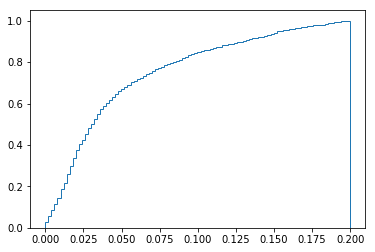

In [66]:
#Clean outliers in the target column
Y = 'avg_consumption'
max_thresh=1

filt = (model_df[Y]>0) & (model_df[Y]<0.2)

model_df.loc[model_df[Y]>max_thresh, Y] = max_thresh

h = plt.hist(model_df[Y][filt], cumulative=True, density=True, bins=100, histtype='step')

In [67]:
'''
Segments:
- Y == 0
- Y in (0,0.03] - low
- Y in (0.03, 0.1] - Med
- Y in (0.1, 1]
'''

np.percentile(model_df[Y][filt].values, [25,50,75])

model_df['Y_cat'] = pd.cut(model_df[Y].values, [0,0.03,0.1,10], right=True, labels = [1,2,3])

model_df = model_df[(model_df['Y_cat'].notnull())]
model_df.Y_cat.value_counts()
#(1-model_df['Y_cat'].isna())

1    763
2    577
3    486
Name: Y_cat, dtype: int64

In [31]:
top_features = ['tariff', 'non_self_generated_electricity_monthly_consumption_kwh',
       'energy', 'years_in_community',
       'uses_of_non_self_generated_electricity_has_fan',
       'non_self_generated_electricity_monthly_expenses', 'educ_years',
       'achieved_important_things_i_want', 'phone_charger_type_of_use',
       'phone', 'hh_size_between_5_18', '3rd_largest_share_of_spending',
       'sleep_time', 'non_self_generated_electricity_unit_price_per_kw',
       'hh_expenses', 'rent']

In [68]:
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

Y = 'Y_cat'

#Shuffle rows
model_df_shuf = model_df.sample(frac=1, random_state=1).reset_index(drop=True)

#Data is shuffled so we can just take bottom 10% for test set
test_pct = 0.1
test_index = int(model_df_shuf.shape[0]) * test_pct
test_df = model_df_shuf.loc[:test_index]
train_df = model_df_shuf.loc[test_index:]


In [95]:
rf_grid = {'n_estimators':[100,200,500], 'max_depth':[5, 10]}
gbdt_grid = {'n_estimators':[50,100,200],'max_depth':[3,5,7],'learning_rate':[0.05,0.1]}


kf = KFold(n_splits=8, random_state=10, shuffle=False)

cf_rf = GridSearchCV(RandomForestClassifier(), rf_grid, cv=kf, scoring='neg_log_loss')
cf_rf.fit(train_df[top_features], train_df[Y])

cf_gb = GridSearchCV(GradientBoostingClassifier(), gbdt_grid, cv=kf, scoring='neg_log_loss')
cf_gb.fit(train_df[top_features], train_df[Y])



GridSearchCV(cv=KFold(n_splits=8, random_state=10, shuffle=False),
       error_score='raise',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_estimators': [50, 100, 200], 'max_depth': [3, 5, 7], 'learning_rate': [0.05, 0.1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_log_loss', verbose=0)

In [97]:
cf_rf.cv_results_['mean_test_score'], cf_gb.cv_results_['mean_test_score']

#cf_gb.__dict__

(array([-0.94, -0.93, -0.93, -0.91, -0.91, -0.91]),
 array([-0.91, -0.9 , -0.92, -0.91, -0.92, -0.96, -0.94, -0.96, -1.03,
        -0.91, -0.92, -0.95, -0.93, -0.96, -1.06, -0.97, -1.04, -1.24]))

In [71]:
from sklearn.metrics import confusion_matrix

confusion_matrix(cf_rf.best_estimator_.predict(test_df[top_features]), test_df[Y])

array([[48, 28, 11],
       [15, 19, 12],
       [ 4, 11, 35]])

In [76]:
from sklearn.utils.multiclass import unique_labels

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    #classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)




Confusion matrix, without normalization
[[48 15  4]
 [29 18 11]
 [11 12 35]]
Normalized confusion matrix
[[0.72 0.22 0.06]
 [0.5  0.31 0.19]
 [0.19 0.21 0.6 ]]


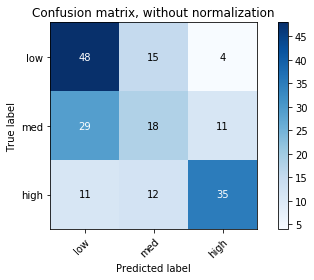

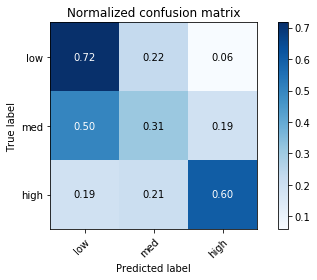

In [98]:
y_pred = cf_rf.best_estimator_.predict(test_df[top_features])

class_names = ['low','med','high']
y_test = test_df[Y]

# Plot non-normalized confusion matrix
plot_confusion_matrix(test_df[Y], y_pred, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [99]:
p_df = pd.DataFrame({'true':test_df[Y], 'pred':y_pred, 'targ':test_df['avg_consumption']})

p_df.groupby(['true','pred']).agg([np.min, np.max, np.mean])

targ                    
               amin      amax      mean
true pred                              
1    1     0.000136  0.029389  0.015569
     2     0.000091  0.028973  0.015731
     3     0.011982  0.022683  0.019327
2    1     0.031102  0.081756  0.051862
     2     0.032916  0.097366  0.057681
     3     0.030680  0.085899  0.054904
3    1     0.102091  0.471874  0.256538
     2     0.104862  0.252342  0.163926
     3     0.108656  1.000000  0.297506

## Find best hi/lo split

In [102]:
from sklearn.metrics import roc_auc_score

In [110]:
cuts = [0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,0.1,0.15,0.2,0.3, 0.4, 0.5]

for c in cuts:
    y_train = 1*(train_df.avg_consumption > c)
    y_test = 1*(test_df.avg_consumption > c)
    rf = RandomForestClassifier(n_estimators=200, max_depth=10)
    rf.fit(train_df[top_features], y_train)
    auc = roc_auc_score(y_test, rf.predict_proba(test_df[top_features])[:,1])
    print('{} : {} : {}'.format(c, y_train.mean(), auc))
    

0.01 : 0.8721850273889227 : 0.6439393939393939
0.02 : 0.696895922093731 : 0.7197552447552448
0.03 : 0.5763846622032867 : 0.7583633556356151
0.04 : 0.47900182592818014 : 0.748729121278141
0.05 : 0.418746195982958 : 0.7481459330143541
0.06 : 0.37918441874619596 : 0.7645447906523857
0.07 : 0.3457090687766281 : 0.7874680306905371
0.08 : 0.31527693244065735 : 0.7936507936507936
0.09 : 0.2903225806451613 : 0.7888211382113822
0.1 : 0.2604990870359099 : 0.8024827586206896
0.15 : 0.18076688983566647 : 0.7412191827085445
0.2 : 0.1278149726110773 : 0.7867218987908643
0.3 : 0.0736457699330493 : 0.8705387205387206
0.4 : 0.049300060864272674 : 0.7991329479768786
0.5 : 0.03530127814972611 : 0.8235955056179775


In [109]:
y_train.mean()

0.0736457699330493